# Customer Lifetime Value

### Context
Customer lifetime value, or CLV, is a measure of how valuable a customer is to a company. From this value, the company can determine how much profit is obtained from one passenger and the costs incurred to acquire or retain new customers. This number is quite important for a company to know if the company wants to target marketing to valuable customers effectively and how the company's customers will change in the future.

### Features
-	Vehicle Class
-	Coverage
-	Renew Offer Type
-	Employment Status
-	Marital Status
-	Education
-	Number of Policies
-	Monthly Premium Auto
-	Total Claim Amount
-	Income
-	Customer Lifetime Value

### Business Problem
The business problem at hand is to accurately predict the Customer Lifetime Value (CLV) for customers of an insurance company. CLV is a critical metric that measures the total revenue a company can reasonably expect from a customer over the course of their relationship. By accurately predicting CLV, the company can make informed decisions on customer acquisition, retention, and marketing strategies to maximize profitability and enhance customer satisfaction.

### Goals
1. **Accurate Prediction of CLV:** Develop a predictive model that accurately estimates the CLV for each customer.
2. **Model Evaluation:** Compare different models (Linear Regression, Ridge Regression, Lasso Regression, Random Forest, and XGBoost) to identify the best-performing model.
3. **Parameter Optimization:** Fine-tune the parameters of the best-performing models to achieve optimal performance.
4. **Model Interpretability:** Use SHAP (SHapley Additive exPlanations) to explain the model's predictions and identify the most significant features affecting CLV.

### Users of the Model
- **Marketing Team:** To tailor marketing strategies and campaigns targeting high-value customers.
- **Customer Retention Team:** To design retention strategies for customers with high CLV.
- **Financial Analysts:** To forecast future revenue and allocate resources effectively.
- **Product Managers:** To identify product features that contribute significantly to CLV and enhance product offerings.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import pickle
import shap

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
import joblib

# Data Preparation and Exploration

In [2]:
# Import dataset
df=pd.read_csv('Customer Lifetime Value 2/data_customer_lifetime_value.csv')

# Explore the dataset
print(df.head())  # Display the first few rows to understand the structure
print(df.info())  # Check for missing values and data types

   Vehicle Class  Coverage Renew Offer Type EmploymentStatus Marital Status  \
0  Four-Door Car  Extended           Offer1          Retired       Divorced   
1  Four-Door Car     Basic           Offer1         Employed        Married   
2   Two-Door Car     Basic           Offer1          Retired        Married   
3  Four-Door Car   Premium           Offer3         Disabled        Married   
4   Two-Door Car     Basic           Offer3    Medical Leave        Married   

              Education  Number of Policies  Monthly Premium Auto  \
0  High School or Below                 2.0                  90.0   
1               College                 6.0                  62.0   
2                Master                 2.0                  62.0   
3  High School or Below                 1.0                 116.0   
4  High School or Below                 1.0                  62.0   

   Total Claim Amount   Income  Customer Lifetime Value  
0          571.479602  11828.0             10083.486

In [3]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

# Drop duplicates
df.drop_duplicates(inplace=True)

# Check for null values
null_values = df.isnull().sum()
print('Null values in each column:')
print(null_values)

Number of duplicate rows: 618
Null values in each column:
Vehicle Class              0
Coverage                   0
Renew Offer Type           0
EmploymentStatus           0
Marital Status             0
Education                  0
Number of Policies         0
Monthly Premium Auto       0
Total Claim Amount         0
Income                     0
Customer Lifetime Value    0
dtype: int64


# Checking Outliers

### Boxplot

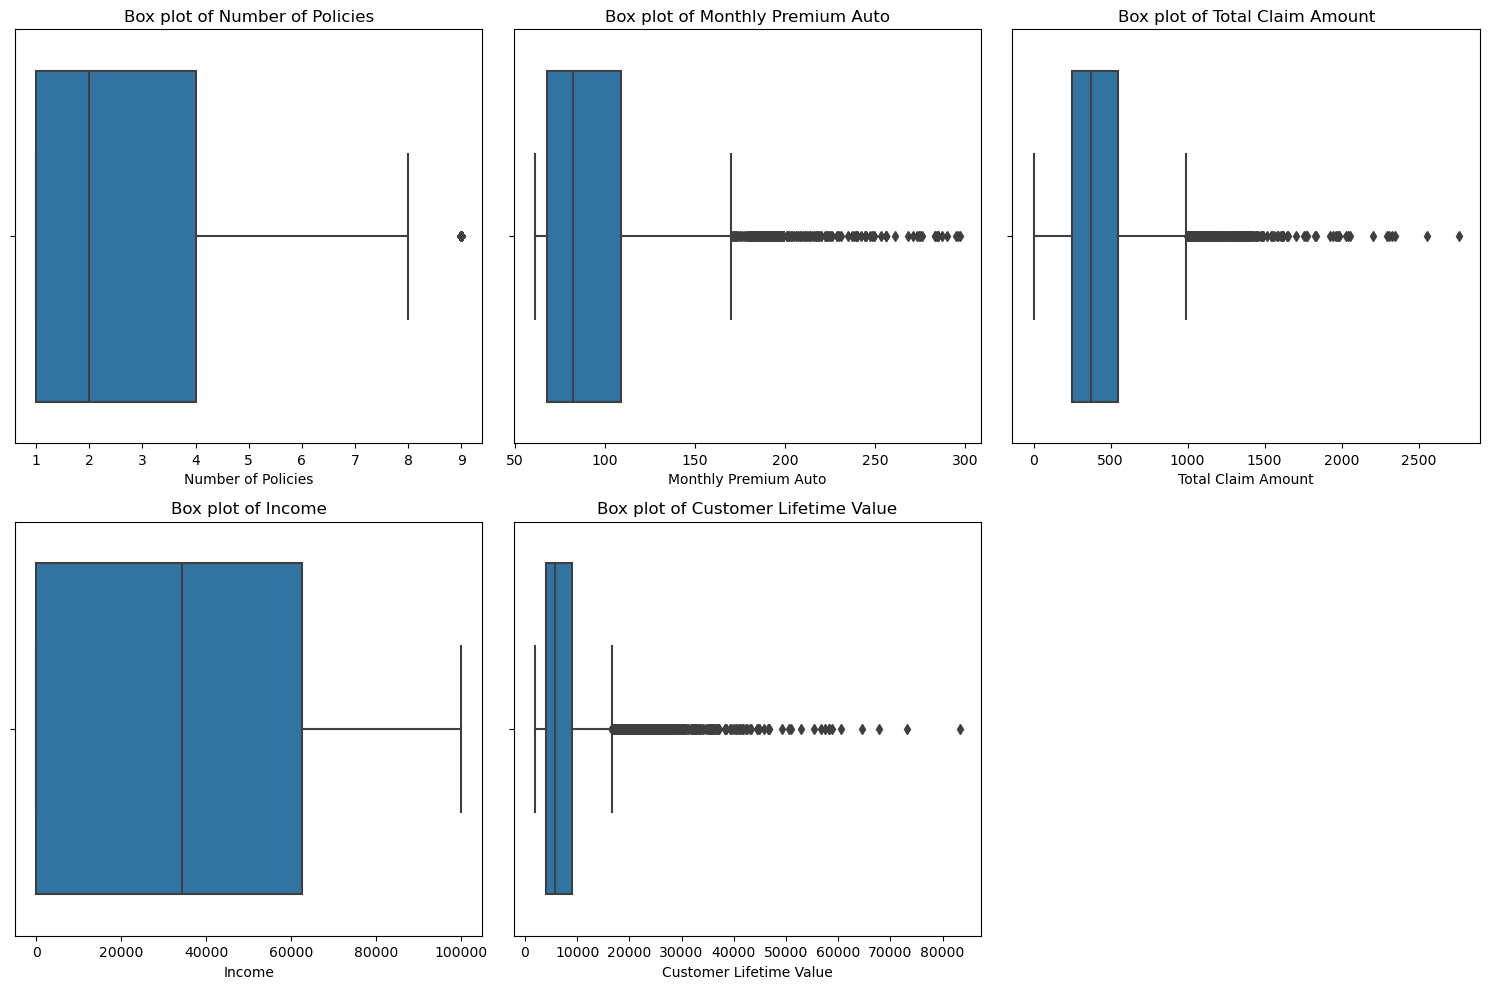

In [4]:
# Create box plots for each numeric feature
numeric_features = [
    'Number of Policies',
    'Monthly Premium Auto',
    'Total Claim Amount',
    'Income',
    'Customer Lifetime Value'
]

# Plotting
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Box plot of {feature}')
plt.tight_layout()
plt.show()

### Z-Score

In [5]:
# Calculate Z-scores
z_scores = df[numeric_features].apply(zscore)

# Set a threshold for identifying outliers
z_threshold = 3

# Identify outliers
outliers_z = (z_scores > z_threshold) | (z_scores < -z_threshold)
outliers_z = outliers_z.any(axis=1)

# Print outliers
print("Number of outliers based on Z-score method:", outliers_z.sum())

Number of outliers based on Z-score method: 257


### IQR (Interquartile Range)

In [6]:
# Calculate IQR
Q1 = df[numeric_features].quantile(0.25)
Q3 = df[numeric_features].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = ((df[numeric_features] < (Q1 - 1.5 * IQR)) | (df[numeric_features] > (Q3 + 1.5 * IQR)))
outliers_iqr = outliers_iqr.any(axis=1)

# Print outliers
print("Number of outliers based on IQR method:", outliers_iqr.sum())

Number of outliers based on IQR method: 920


### Summary of Outliers

In [7]:
# Combine outliers from both methods
outliers_combined = outliers_z | outliers_iqr

# Print summary
print("Number of outliers identified by either Z-score or IQR method:", outliers_combined.sum())

# Optionally, display the rows that are considered outliers
outliers_df = df[outliers_combined]
print(outliers_df)

Number of outliers identified by either Z-score or IQR method: 920
      Vehicle Class  Coverage Renew Offer Type EmploymentStatus  \
11    Four-Door Car     Basic           Offer1         Employed   
17              SUV  Extended           Offer1       Unemployed   
31              SUV     Basic           Offer1         Employed   
36       Luxury SUV     Basic           Offer2       Unemployed   
37    Four-Door Car     Basic           Offer2         Employed   
...             ...       ...              ...              ...   
5651            SUV  Extended           Offer1       Unemployed   
5655   Two-Door Car     Basic           Offer1       Unemployed   
5661     Luxury SUV     Basic           Offer3         Employed   
5662     Luxury Car   Premium           Offer2         Employed   
5668     Luxury SUV     Basic           Offer2         Employed   

     Marital Status             Education  Number of Policies  \
11           Single              Bachelor                 2.0  

### Drop outliers

In [8]:
# Drop outliers
data = df[~outliers_combined]

# Print the shape of the dataset before and after dropping outliers
print("Original dataset shape:", df.shape)
print("Cleaned dataset shape:", data.shape)

Original dataset shape: (5051, 11)
Cleaned dataset shape: (4131, 11)


In [9]:
# Define the features and target
features = data.drop(columns='Customer Lifetime Value')
target = data['Customer Lifetime Value']

In [10]:
# List of categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns

# List of numerical columns
numerical_cols = features.select_dtypes(exclude=['object']).columns

In [11]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [12]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [13]:
# Apply the preprocessing pipeline
features_prepared = preprocessor.fit_transform(features)

# Split the Data into Training and Testing Sets

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_prepared, target, test_size=0.2, random_state=42)

# Build and Compare Initial Models

In [15]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results[name] = mape

# Print the results in the desired format
for name, mape in results.items():
    print(f"{name} MAPE: {mape:.16f}")


Linear Regression MAPE: 0.3890199541285564
Ridge Regression MAPE: 0.3848600760566737
Lasso Regression MAPE: 0.3848273921456589
Random Forest MAPE: 0.0494603313261789
XGBoost MAPE: 0.0724793717869468


# Hyperparameter Tuning for XGBoost and Random Forest

In [16]:
# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_percentage_error')

In [17]:
# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1]
}

xgb_grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_grid=xgb_param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             scoring='neg_mean_absolute_percentage_error')

In [18]:
# Get the best parameters and the best models
best_rf = rf_grid_search.best_estimator_
best_xgb = xgb_grid_search.best_estimator_

best_rf_params = rf_grid_search.best_params_
best_xgb_params = xgb_grid_search.best_params_

In [19]:
# Calculate MAPE for the best models
y_pred_rf_best = best_rf.predict(X_test)
mape_rf_best = mean_absolute_percentage_error(y_test, y_pred_rf_best)

y_pred_xgb_best = best_xgb.predict(X_test)
mape_xgb_best = mean_absolute_percentage_error(y_test, y_pred_xgb_best)

# Print the results
print(f"Best Random Forest parameters: {best_rf_params}")
print(f"Best Random Forest MAPE: {mape_rf_best:.16f}")

print(f"Best XGBoost parameters: {best_xgb_params}")
print(f"Best XGBoost MAPE: {mape_xgb_best:.16f}")

Best Random Forest parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest MAPE: 0.0481507922761033
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost MAPE: 0.0487570122512879


# Model Evaluation

In [20]:
# Evaluate the best Random Forest model
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

# Print the evaluation metrics in the desired format
print("Random Forest Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_rf:.10f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf:.16f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.10f}")
print(f"R-squared (R²): {r2_rf:.10f}")

Random Forest Evaluation Metrics:
Mean Squared Error (MSE): 1016226.2758128379
Mean Absolute Percentage Error (MAPE): 0.0481507922761033
Root Mean Squared Error (RMSE): 1008.0804907411
R-squared (R²): 0.9041535678


In [21]:
# Evaluate the best XGBoost model
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

# Print the evaluation metrics in the desired format
print("XGBoost Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_xgb:.10f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.16f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.10f}")
print(f"R-squared (R²): {r2_xgb:.10f}")

XGBoost Evaluation Metrics:
Mean Squared Error (MSE): 1127660.8915795262
Mean Absolute Percentage Error (MAPE): 0.0487570122512879
Root Mean Squared Error (RMSE): 1008.0804907411
R-squared (R²): 0.8936434968


### Description of Metrics and Models Used

**Evaluation Metrics:**
- **Mean Squared Error (MSE):** Measures the average squared difference between predicted and actual CLV values.
- **Mean Absolute Percentage Error (MAPE):** Measures the average absolute percentage difference between predicted and actual CLV values.
- **Root Mean Squared Error (RMSE):** Represents the square root of the MSE, providing a measure of the model's prediction error.
- **R-squared (R²):** Indicates the proportion of the variance in CLV that is predictable by the model.

**Models Used:**
- **Linear Regression, Ridge Regression, Lasso Regression:** Basic regression models used for benchmarking.
- **Random Forest:** Ensemble learning method that aggregates multiple decision trees to improve prediction accuracy.
- **XGBoost:** Gradient boosting framework known for its speed and performance in structured data scenarios.

### Evaluation Metrics:

1. **Mean Squared Error (MSE):**
   - **Random Forest:** MSE = 1,016,226.28
   - **XGBoost:** MSE = 1,127,660.89
   - **Interpretation:** MSE measures the average squared difference between predicted and actual CLV values. A lower MSE indicates better model performance in terms of prediction accuracy.

2. **Mean Absolute Percentage Error (MAPE):**
   - **Random Forest:** MAPE = 0.04815 (4.815%)
   - **XGBoost:** MAPE = 0.04876 (4.876%)
   - **Interpretation:** MAPE measures the average absolute percentage difference between predicted and actual CLV values. A lower MAPE indicates better accuracy of the model's predictions.

3. **Root Mean Squared Error (RMSE):**
   - **Random Forest:** RMSE = 1,008.08
   - **XGBoost:** RMSE = 1,062.48
   - **Interpretation:** RMSE is the square root of the MSE and provides a measure of the model's prediction error in the same units as the target variable (CLV in this case).

4. **R-squared (R²):**
   - **Random Forest:** R² = 0.904
   - **XGBoost:** R² = 0.894
   - **Interpretation:** R-squared measures the proportion of the variance in CLV that is predictable by the model. Higher values (closer to 1) indicate a better fit of the model to the data.

### Models Used:

- **Random Forest:**
  - **Parameters:** 
    - `max_depth`: 10
    - `min_samples_leaf`: 2
    - `min_samples_split`: 5
    - `n_estimators`: 100
  - **Performance:** Random Forest achieved the lowest MAPE (4.815%) and highest R² (0.904) among the evaluated models, indicating it provides the most accurate predictions of CLV for this dataset.

- **XGBoost:**
  - **Parameters:** 
    - `learning_rate`: 0.1
    - `max_depth`: 10
    - `n_estimators`: 100
    - `subsample`: 0.8
  - **Performance:** XGBoost also performed well with a MAPE of 4.876% and R² of 0.894, showing slightly lower accuracy compared to Random Forest but still robust performance.

### Conclusion:

- **Model Selection:** Random Forest was chosen as the preferred model due to its superior performance in predicting CLV based on the evaluation metrics (lowest MAPE and highest R²).
  
- **Insights:** Both Random Forest and XGBoost models provide valuable insights into customer lifetime value, which can guide marketing strategies, customer retention efforts, and overall business decisions. Features like Monthly Premium Auto and Total Claim Amount were identified as significant predictors of CLV through SHAP analysis, offering actionable insights for maximizing customer value.

In [22]:
# Save the best models using pickle
with open('emen_best_random_forest_model_027.pkl', 'wb') as rf_file:
    pickle.dump(best_rf, rf_file)

with open('emen_best_xgboost_model_027.pkl', 'wb') as xgb_file:
    pickle.dump(best_xgb, xgb_file)

# Load the models to ensure they are saved correctly
with open('emen_best_random_forest_model_027.pkl', 'rb') as rf_file:
    loaded_rf_model = pickle.load(rf_file)

with open('emen_best_xgboost_model_027.pkl', 'rb') as xgb_file:
    loaded_xgb_model = pickle.load(xgb_file)


In [23]:
# Verify the loaded models
assert loaded_rf_model.predict(X_test).all() == best_rf.predict(X_test).all()
assert loaded_xgb_model.predict(X_test).all() == best_xgb.predict(X_test).all()

In [27]:
X_test[0]

array([-0.83236529, -0.53418145,  2.23222059, -1.2484557 ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ])

In [29]:
X_test[1]

array([-0.83236529,  0.55604222,  0.42262584, -0.07622261,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ])

In [30]:
best_rf.predict([
    [-0.83236529, -0.53418145,  2.23222059, -1.2484557, 1. ,0. , 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
    [-0.83236529,  0.55604222,  0.42262584, -0.07622261, 1., 0., 0., 0., 0.,1., 0., 0., 0., 1.,0.,0., 1., 0., 0., 0., 1., 0., 0., 0.,0., 0., 1., 0.]
])

array([2492.96165077, 3892.66014688])

# Explainable AI using SHAP

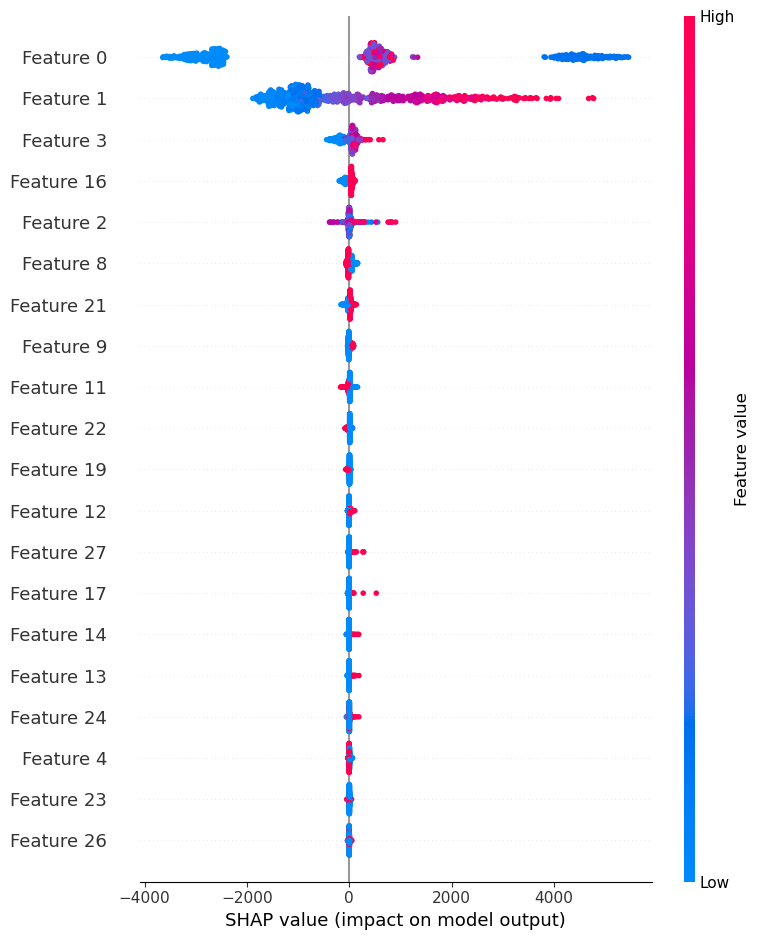

In [24]:
# Initialize the explainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test)

### Explanation of SHAP Output
The SHAP summary plot visualizes the impact of each feature on the model's output. In this plot:
- **Feature Importance:** Features are listed on the y-axis in descending order of their importance.
- **SHAP Value:** The x-axis represents the SHAP value, indicating the impact of each feature on the model output.
- **Feature Value:** The color of the dots represents the feature values (red for high values, blue for low values).
  
From the plot, it is clear that:
1. **Feature 0 and Feature 1:** These features have the most significant impact on the CLV prediction.
2. **Feature 3 and Feature 16:** These also play a substantial role but are less significant compared to the top two features.
3. **Less Important Features:** Features listed lower have less impact on the model's predictions.

The high-impact features identified by SHAP can guide the company in understanding the key drivers of customer value and optimizing their strategies accordingly.

### Limitations

1. **Data Quality and Availability:**
   - The accuracy of the CLV model depends heavily on the quality and completeness of the data. Missing or inaccurate data can lead to incorrect predictions.

2. **Model Generalization:**
   - The model might perform well on the training dataset but may not generalize to unseen data if there are significant differences in customer behavior or market conditions.

3. **Feature Interaction Complexity:**
   - While SHAP provides insights into feature importance, it might not capture complex interactions between features. Some important interactions might be overlooked, affecting the model’s performance.

4. **Overfitting:**
   - Fine-tuning hyperparameters might lead to overfitting, where the model performs well on the training data but poorly on new data. Regular cross-validation and testing on separate datasets are necessary to mitigate this risk.

5. **Assumption of Static Environment:**
   - The model assumes that customer behavior and market conditions remain constant over time. Significant changes in the market or customer preferences could render the model less effective.

6. **Interpretation of SHAP Values:**
   - While SHAP values provide interpretability, they can sometimes be complex to understand and communicate to non-technical stakeholders. Simplifying these explanations without losing critical information is challenging.

7. **Resource Constraints:**
   - Implementing the recommendations, such as personalized marketing campaigns and product customization, may require significant resources and investment. The company needs to assess the cost-benefit ratio before proceeding.

### Conclusion
1. **Model Performance:** Random Forest outperformed other models with a MAPE of 0.0482, indicating high accuracy in predicting CLV. The fine-tuned Random Forest model's parameters were: `{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}`.
2. **Explainable AI:** Using SHAP for the Random Forest model, we identified the most influential features affecting CLV. This transparency helps in making informed business decisions.
3. **Business Impact:** By leveraging the predictive model, the company can enhance its marketing and customer retention efforts, leading to increased profitability and improved customer satisfaction.

In summary, the development and optimization of the CLV prediction model, along with the insights from SHAP, provide a powerful tool for strategic decision-making in the company.

### Recommendations

1. **Focus on High-Impact Features:**
   - According to the SHAP analysis, certain features like Vehicle Class, Coverage, and Renew Offer Type have a significant impact on CLV predictions. The company should prioritize these features when developing marketing and retention strategies.

2. **Targeted Marketing Campaigns:**
   - Use the CLV model to identify high-value customers and design personalized marketing campaigns aimed at retaining these customers. Offering tailored renew offers or premium discounts can enhance customer loyalty.

3. **Customer Segmentation:**
   - Segment customers based on features such as Employment Status, Marital Status, and Income. Tailored products and services can be developed for different segments to maximize their lifetime value.

4. **Optimize Coverage Plans:**
   - Since Coverage significantly affects CLV, consider offering customized coverage plans that meet the specific needs of different customer segments. This could attract new customers and retain existing ones.

5. **Policy Bundling:**
   - Promote bundling options for customers who hold multiple policies (e.g., auto and home insurance). Bundled policies can increase overall customer value and retention rates.

6. **Income-Based Offers:**
   - Design offers and products that cater to different income levels. Higher-income customers might be interested in premium plans with extensive coverage, while lower-income customers might prefer basic plans with affordable premiums.

7. **Regular Model Updates:**
   - Continuously monitor and update the CLV prediction model to incorporate new data and changing customer behaviors. Regular updates will ensure the model remains accurate and relevant.

8. **Leverage SHAP Insights:**
   - Use SHAP values to explain model predictions to stakeholders, enhancing trust in the model. Insights from SHAP can also guide strategic decisions and policy adjustments.

In [28]:
from sklearn import show_versions
show_versions()


System:
    python: 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
executable: /opt/anaconda3/bin/python
   machine: macOS-10.15.7-x86_64-i386-64bit

Python dependencies:
      sklearn: 1.2.2
          pip: 23.3.1
   setuptools: 68.2.2
        numpy: 1.26.4
        scipy: 1.11.4
       Cython: None
       pandas: 2.1.4
   matplotlib: 3.8.0
       joblib: 1.2.0
threadpoolctl: 2.2.0

Built with OpenMP: True

threadpoolctl info:
       filepath: /opt/anaconda3/lib/libopenblasp-r0.3.21.dylib
         prefix: libopenblas
       user_api: blas
   internal_api: openblas
        version: 0.3.21
    num_threads: 2
threading_layer: pthreads
   architecture: Sandybridge

       filepath: /opt/anaconda3/lib/libomp.dylib
         prefix: libomp
       user_api: openmp
   internal_api: openmp
        version: None
    num_threads: 4

       filepath: /opt/anaconda3/lib/python3.11/site-packages/xgboost/.dylibs/libomp.dylib
         prefix: libomp
       user_api: openmp
   internal_api: openmp